In [1]:
import os
import dask

In [2]:
from distributed.security import Security
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

In [3]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import HTCondorCluster
from dask_jobqueue.htcondor import HTCondorJob

In [4]:
from coffea_casa.coffea_casa_method import CoffeaCasaCluster

In [5]:
fileset = {
    'Jets': { 'files': ['root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root'],
             'treename': 'Events'
            }
}

[ADL1](https://github.com/iris-hep/adl-benchmarks-index): Plot the Missing ET in an event (loop over events)

In [6]:
# This program plots an event-level variable (in this case, MET, but switching it is as easy as a dict-key change). It also demonstrates an easy use of the book-keeping cutflow tool, to keep track of the number of events processed.
# The processor class bundles our data analysis together while giving us some helpful tools.  It also leaves looping and chunks to the framework instead of us.
class METProcessor(processor.ProcessorABC):
    def __init__(self):
        # Bins and categories for the histogram are defined here. For format, see https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Hist.html && https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Bin.html
        self._columns = ['MET_pt']
        dataset_axis = hist.Cat("dataset", "")
        MET_axis = hist.Bin("MET", "MET [GeV]", 50, 0, 100)
        # The accumulator keeps our data chunks together for histogramming. It also gives us cutflow, which can be used to keep track of data.
        self._accumulator = processor.dict_accumulator({
            'MET': hist.Hist("Counts", dataset_axis, MET_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })

    @property
    def accumulator(self):
        return self._accumulator

    @property
    def columns(self):
        return self._columns

    def process(self, df):
        output = self.accumulator.identity()
        # This is where we do our actual analysis. The df has dict keys equivalent to the TTree's.
        dataset = df['dataset']
        MET = df['MET_pt']
        # We can define a new key for cutflow (in this case 'all events'). Then we can put values into it. We need += because it's per-chunk (demonstrated below)
        output['cutflow']['all events'] += MET.size
        output['cutflow']['number of chunks'] += 1
        # This fills our histogram once our data is collected. Always use .flatten() to make sure the array is reduced. The output key will be as defined in __init__ for self._accumulator; the hist key ('MET=') will be defined in the bin.
        output['MET'].fill(dataset=dataset, MET=MET.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [7]:
# Wrapper aroung dask_queue.HTCondorCluster, that allowed to launch Dask on an HTCondor cluster with a shared file system and customised for our analysis facility.
# More information: https://jobqueue.dask.org/en/latest/generated/dask_jobqueue.HTCondorCluster.html
client = CoffeaCasaCluster(worker_image="coffeateam/coffea-casa-analysis:0.1.50", autoscale=False, max_scale=10, tls=True)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tls://192.168.49.162:8787
distributed.scheduler - INFO -   dashboard at:                     :8786
distributed.core - INFO - Event loop was unresponsive in Scheduler for 11.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.scheduler - INFO - Receive client connection: Client-b4984fb6-c5d7-11ea-8bda-e2e35e4d5cea
distributed.core - INFO - Starting established connection


In [8]:
exe_args = {
        'client': client,
    }

In [9]:
# A convenience wrapper to submit jobs for a file set, which is a dictionary of dataset: [file list] entries.
# Supports only uproot reading, via the LazyDataFrame class. 
# * Parameters: processor_instance (ProcessorABC) – An instance of a class deriving from ProcessorABC
# * Parameters: executor (callable) – A function that takes 3 arguments: items, function, accumulator and performs some action equivalent to: `for item in items: accumulator += function(item)`. See iterative_executor, futures_executor, dask_executor, or parsl_executor for available options.
# * Parameters: executor_args (dict, optional) – Arguments to pass to executor. 
output = processor.run_uproot_job(fileset,
                                treename = 'Events',
                                processor_instance = METProcessor(),
                                executor = processor.dask_executor,
                                executor_args = exe_args
                                )

[                                        ] | 0% Completed | 29.3s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.183.41:33090', name: htcondor--3469089.0--, memory: 0, processing: 1>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.183.41:33090
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.183.41:33091', name: htcondor--3469094.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.183.41:33091
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed | 31.7s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.91:33116', name: htcondor--3469090.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.91:33116
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed | 31.8s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.89:33116', name: htcondor--3469091.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.89:33116
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed | 31.9s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.91:33117', name: htcondor--3469092.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.91:33117
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed | 32.3s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.168:33158', name: htcondor--3469088.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.168:33158
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed | 32.5s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.89:33117', name: htcondor--3469095.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.89:33117
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed | 32.7s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.91:33118', name: htcondor--3469096.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.91:33118
distributed.core - INFO - Starting established connection


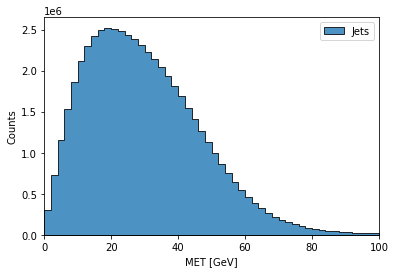

In [10]:
# Generates a 1D histogram from the data output to the 'MET' key. fill_opts are optional, to fill the graph (default is a line).
hist.plot1d(output['MET'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [11]:
# Easy way to print all cutflow dict values. Can just do print(output['cutflow']["KEY_NAME"]) for one.
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
number of chunks 534
